In [ ]:
!pip uninstall -y fastai
!pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

# **Multi-Class Object Detection with using Faster-rcnn**

---

![images](https://i.pinimg.com/originals/a7/a2/e1/a7a2e105d70e2a66117cf7a862d7bbb3.png)
![images](https://i.pinimg.com/originals/cf/bc/fc/cfbcfcebd4cabca94912035985e954f3.png)

---

## **Table of contensts**

* [Import utilities](#Import-utilities)

* [Extract info. from xml files](#Extract-info.-from-xml-files)

* [Make dataframe from extracted information](#Make-dataframe-from-extracted-information)

* [Separate train and validation data](#Separate-train-and-validation-data)

* [View sample](#View-sample)

* [Download pretrained model](#Download-pretrained-model)

* [Train object detection model](#Train-object-detection-model)

* [Test model](#Test-model)

In [ ]:
!git clone https://github.com/hungvotranchi/ComputerVision.git

## **Import utilities**

In [1]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

from sklearn import preprocessing 
import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader
from torch.utils.data import SequentialSampler

In [2]:
BASE_PATH = "../input/pascal-voc-2012/VOC2012"
XML_PATH = os.path.join(BASE_PATH, "Annotations")
IMG_PATH = os.path.join(BASE_PATH, "JPEGImages")
XML_FILES = [os.path.join(XML_PATH, f) for f in os.listdir(XML_PATH)]


## **Extract info. from xml files**

In [3]:
os.chdir("..")
from src.xml_parse import xml_files_to_df
df = xml_files_to_df(XML_FILES)
df.head()

## **Make dataframe from extracted information**

---

In [5]:
# check values for per class
df['names'].value_counts()

person         17401
chair           3056
car             2492
dog             1598
bottle          1561
cat             1277
bird            1271
pottedplant     1202
sheep           1084
boat            1059
aeroplane       1002
tvmonitor        893
sofa             841
bicycle          837
horse            803
motorbike        801
diningtable      800
cow              771
train            704
bus              685
Name: names, dtype: int64

In [6]:
# remove .jpg extension from image_id 
df['img_id'] = df['image_id'].apply(lambda x:x.split('.')).map(lambda x:x[0])
df.drop(columns=['image_id'], inplace=True)
df.head()

,names,boxes,xml_path,img_path,img_id
0,person,"[67, 56, 269, 369]",../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...,2011_006424
1,sofa,"[34, 1, 498, 242]",../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...,2010_003717
2,bottle,"[432, 305, 500, 332]",../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...,2010_003717
3,tvmonitor,"[21, 1, 193, 95]",../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...,2009_000488
4,cat,"[224, 159, 287, 229]",../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...,2009_000488


In [7]:
# classes need to be in int form so we use LabelEncoder for this task
enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['names'])
df['labels'] = np.stack(df['labels'][i]+1 for i in range(len(df['labels']))) 

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3347: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [8]:
classes = df[['names','labels']].value_counts()
classes

names        labels
person       15        17401
chair        9          3056
car          7          2492
dog          12         1598
bottle       5          1561
cat          8          1277
bird         3          1271
pottedplant  16         1202
sheep        17         1084
boat         4          1059
aeroplane    1          1002
tvmonitor    20          893
sofa         18          841
bicycle      2           837
horse        13          803
motorbike    14          801
diningtable  11          800
cow          10          771
train        19          704
bus          6           685
dtype: int64

In [9]:
# make dictionary for class objects so we can call objects by their keys.
classes= {1:'aeroplane',2:'bicycle',3:'bird',4:'boat',5:'bottle',6:'bus',7:'car',8:'cat',9:'chair',10:'cow',11:'diningtable',12:'dog',13:'horse',14:'motorbike',15:'person',16:'pottedplant',17:'sheep',18:'sofa',19:'train',20:'tvmonitor'}

In [10]:
# bounding box coordinates point need to be in separate columns

df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1

df[['xmin','ymin','xmax','ymax']]=np.stack(df['boxes'][i] for i in range(len(df['boxes'])))

df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(np.float)
df['ymin'] = df['ymin'].astype(np.float)
df['xmax'] = df['xmax'].astype(np.float)
df['ymax'] = df['ymax'].astype(np.float)

In [11]:
# drop names column since we dont need it anymore
df.drop(columns=['names'], inplace=True)
df.head()

,xml_path,img_path,img_id,labels,xmin,ymin,xmax,ymax
0,../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...,2011_006424,15,67.0,56.0,269.0,369.0
1,../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...,2010_003717,18,34.0,1.0,498.0,242.0
2,../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...,2010_003717,5,432.0,305.0,500.0,332.0
3,../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...,2009_000488,20,21.0,1.0,193.0,95.0
4,../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...,2009_000488,8,224.0,159.0,287.0,229.0


In [12]:
len(df['img_id'].unique())

17125

## **Separate train and validation data**

In [13]:
image_ids = df['img_id'].unique()
valid_ids = image_ids[-4000:]
train_ids = image_ids[:-4000]
len(train_ids)

13125

In [14]:
valid_df = df[df['img_id'].isin(valid_ids)]
train_df = df[df['img_id'].isin(train_ids)]
valid_df.shape, train_df.shape

((9108, 8), (31030, 8))

## **Make dataset by Dataset Module** 

In [17]:
from src.dataset import VOCDataset, get_transform_train, get_transform_valid, collate_fn

train_dataset = VOCDataset(train_df, IMG_PATH , get_transform_train())
valid_dataset = VOCDataset(valid_df, IMG_PATH, get_transform_valid())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()


train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)



In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **View sample**

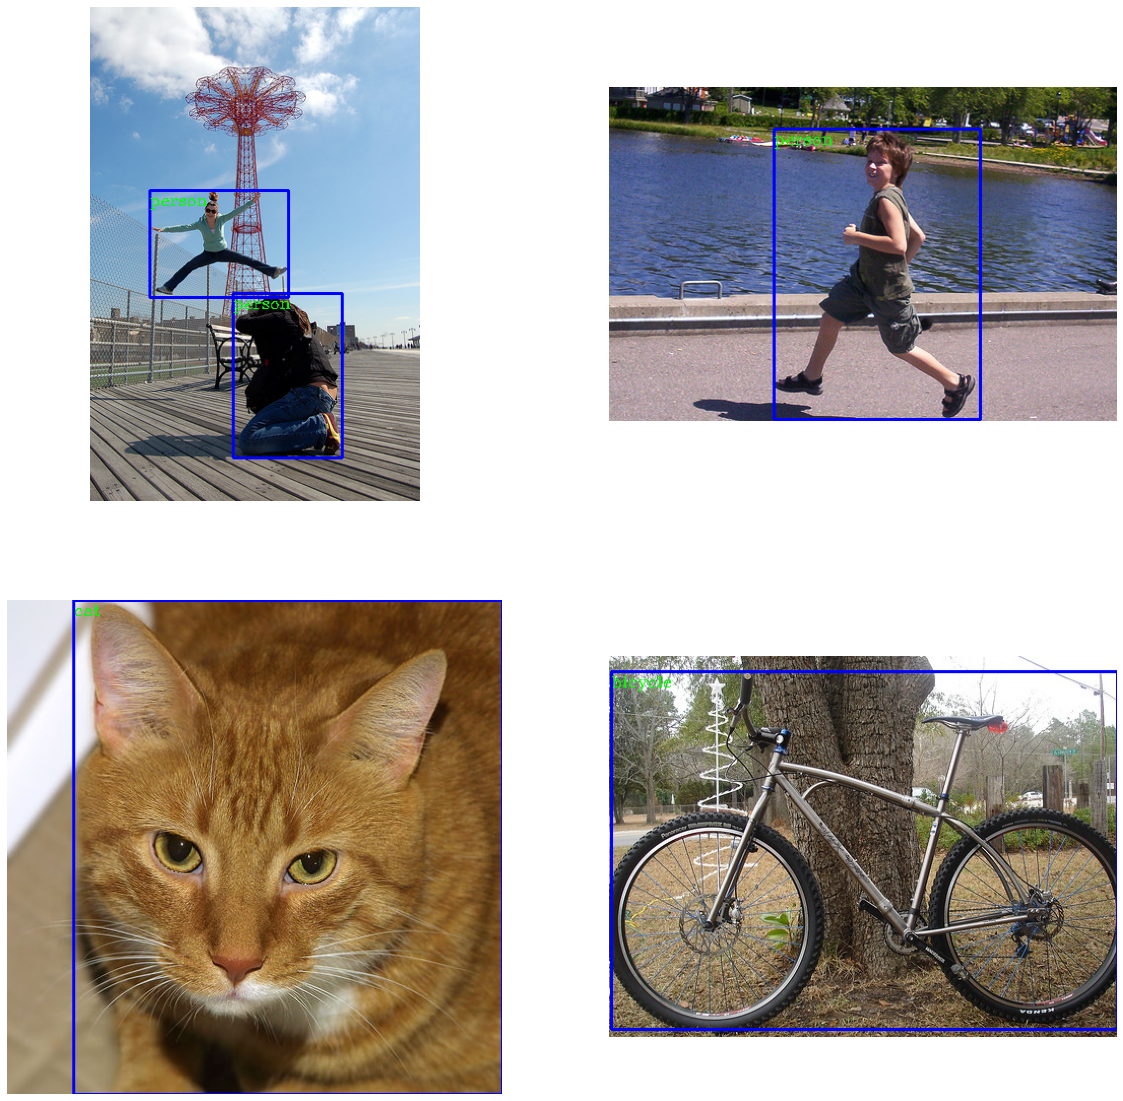

In [19]:
from src.plot_obj import plot_obj

plot_obj(train_data_loader, device=device, classes= classes)
    

# Download pretrained model

In [20]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [21]:
num_classes = 21  

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [22]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## **Download modules for model training**

In [23]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-5wgr_g9_
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-5wgr_g9_
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=272378 sha256=56a2fd7bf89afe7c12794565198678c785076b94d604f9b4cb8a43869a1f2c98
  Stored in directory: /tmp/pip-ephem-wheel-cache-48k7lebd/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools


In [24]:
!git clone https://github.com/pytorch/vision.git
!cd vision;cp references/detection/utils.py ../;cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 502454, done.
remote: Counting objects: 100% (16064/16064), done.
remote: Compressing objects: 100% (792/792), done.
remote: Total 502454 (delta 15266), reused 16009 (delta 15245), pack-reused 486390
Receiving objects: 100% (502454/502454), 976.01 MiB | 46.51 MiB/s, done.
Resolving deltas: 100% (468510/468510), done.


In [25]:
from engine import train_one_epoch, evaluate
import utils

## **Train object detection model**

In [26]:
# let's train it for 2 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)

Epoch: [0]  [   0/3282]  eta: 0:58:06  lr: 0.000010  loss: 3.3141 (3.3141)  loss_classifier: 2.9915 (2.9915)  loss_box_reg: 0.3077 (0.3077)  loss_objectness: 0.0127 (0.0127)  loss_rpn_box_reg: 0.0022 (0.0022)  time: 1.0624  data: 0.4165  max mem: 4004
Epoch: [0]  [  10/3282]  eta: 0:42:23  lr: 0.000060  loss: 3.1581 (3.1604)  loss_classifier: 2.8813 (2.9024)  loss_box_reg: 0.2048 (0.2354)  loss_objectness: 0.0109 (0.0107)  loss_rpn_box_reg: 0.0067 (0.0119)  time: 0.7775  data: 0.0480  max mem: 6727
Epoch: [0]  [  20/3282]  eta: 0:39:09  lr: 0.000110  loss: 3.0839 (3.1653)  loss_classifier: 2.8395 (2.8583)  loss_box_reg: 0.2581 (0.2793)  loss_objectness: 0.0106 (0.0154)  loss_rpn_box_reg: 0.0067 (0.0123)  time: 0.7033  data: 0.0114  max mem: 6727
Epoch: [0]  [  30/3282]  eta: 0:38:41  lr: 0.000160  loss: 3.0216 (3.0760)  loss_classifier: 2.7402 (2.7586)  loss_box_reg: 0.2718 (0.2892)  loss_objectness: 0.0119 (0.0147)  loss_rpn_box_reg: 0.0097 (0.0135)  time: 0.6787  data: 0.0118  max me

In [27]:
torch.save(model.state_dict(), 'faster_rcnn_state.pth')

# **Test model**

In [28]:
# load  a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

WEIGHTS_FILE = "./faster_rcnn_state.pth"

num_classes = 21

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the traines weights
model.load_state_dict(torch.load(WEIGHTS_FILE))

model = model.to(device)

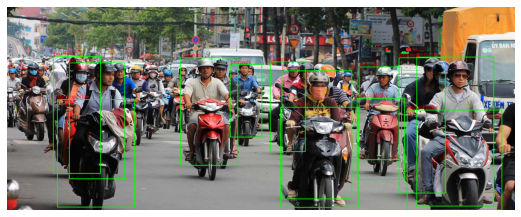

In [31]:
pred_path = "/kaggle/input/private"
pred_files = [os.path.join(pred_path,f) for f in os.listdir(pred_path)]

plt.figure(figsize=(20,60))
for i, images in enumerate(pred_files):
    if i > 19:break
    plt.subplot(10,2,i+1)
    names,boxes,sample = obj_detector(images)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 220, 0), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]-5),cv2.FONT_HERSHEY_COMPLEX ,0.7,(220,0,0),1,cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)
#     plt.savefig('save_image.png', bbox_inches='tight')  # if you want to save result

---

# **Thats all folks,please consider uplvote this notebook, Thanks for your time.**